In [1]:
import pandas as pd
import numpy as np
import torch
import os 
import sys
from Bio import SeqIO
from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein, SamplingConfig
from esm.utils.constants.models import ESM3_OPEN_SMALL
from torch_geometric.data import Dataset
from tqdm import tqdm
from huggingface_hub import login
import torch, gc
import pickle
import matplotlib



class StringDB_Dataset(Dataset):
    # esm_model must end in .pt for local model.
    def __init__(self,data_path,fasta_path,esm_model='ESM3_OPEN_SMALL'):
        self.data_path = data_path
        self.fasta_path = fasta_path
        self.esm_model = esm_model
        self.data_cols = self.get_column_names()
        '''
        self.data = self.data.dropna()
        self.data = self.data.reset_index(drop=True)
        self.data = self.data.drop_duplicates()
        self.data = self.data.reset_index(drop=True)
        self.data = self.data.drop(columns=['Unnamed: 0'])
        '''
    
    def get_column_names(self):
        if os.path.exists(self.data_path):
            with open(self.data_path) as f:
                return f.readline().strip().split('\t')
        else:
            Exception('File not found, check filepath')

    
    def get_esm_embeddings(self,out_dir):
        client = ESM3.from_pretrained(self.esm_model)
        with open(self.fasta_path) as handle:
            iter = 0
            curr_seq = 0
            for record in tqdm(SeqIO.parse(handle, "fasta")):
                label = record.id
                if not os.path.exists(out_dir):
                    os.makedirs(out_dir)
                output_file = os.path.join(out_dir,f"{label}.pt")
                if len(record.seq) > 1024:
                    if len(record.seq) > 4096:
                        continue
                    seq = record.seq[:1024]
                else:
                    seq = record.seq
                
                #if iter % 5 == 0:
                curr_seq += len(str(seq))
                if curr_seq > 4096*2:
                    torch.cuda.empty_cache()
                    gc.collect()
                    curr_seq = len(str(seq))

                protein = ESMProtein(sequence=(str(seq)))
                protein_tensor = client.encode(protein)
                f = open("debug.txt", "a")
                f.write(f"iter: {iter},{len(str(seq))}\n")
                f.close()
                output = client.forward_and_sample(protein_tensor, SamplingConfig(return_mean_embedding=True)).mean_embedding.detach().cpu().numpy()
                result = {"label": record.id, "embeddings": output}
                
                
                iter+=1

                torch.save(result,output_file)


    def load_data(self,data_path):
        if os.path.exists(data_path):
            data = pd.read_csv(data_path)
            return data

In [ ]:
path = '/mnt/d/data/stitchdb.txt'
fasta_path = '/mnt/d/data/stringdb_seq_human.fa'
local_model = '/mnt/d/data/esm3_sm_open_v1.pt'
out_dir = '/mnt/d/data/stringdb_embeddings'
data = StringDB_Dataset(path,fasta_path,esm_model='esm3_sm_open_v1')
data.get_esm_embeddings(out_dir)

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/cjiang/miniconda3/envs/cs224w/lib/python3.10/site-packages/esm/pretrained.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
2876it [05:37, 

In [ ]:
pd.read_csv('./debug.txt',names=['iter','len'])['len']

0          current string length: 429
1          current string length: 203
2         current string length: 1140
3          current string length: 650
4          current string length: 579
                     ...             
20321      current string length: 229
20322      current string length: 919
20323      current string length: 859
20324      current string length: 432
20325     current string length: 2048
Name: len, Length: 20326, dtype: object

In [ ]:
with open(path, 'r') as file:
    for _ in range(10):
        print(file.readline().strip())

chemical	protein	experimental_direct	experimental_transferred	prediction_direct	prediction_transferred	database_direct	database_transferred	textmining_direct	textmining_transferred	combined_score
CIDm91758680	190486.XAC0787	0	0	0	0	0	0	0	161	161
CIDm91758680	190486.XAC0788	0	0	0	0	0	0	0	187	187
CIDm91758680	190486.XAC1728	0	0	0	0	0	0	0	161	161
CIDm91758680	190486.XAC1855	0	0	0	0	0	0	0	210	210
CIDm91758680	190486.XAC2361	0	0	0	0	0	0	0	161	161
CIDm91758680	190486.XAC2462	0	0	0	0	0	0	0	173	173
CIDm91758680	190486.XAC2928	0	0	0	0	0	0	0	161	161
CIDm91758680	190486.XAC3041	0	0	0	0	0	0	0	161	161
CIDm91758680	190486.XAC3368	0	0	0	0	0	0	0	161	161


In [ ]:
path = '/mnt/d/data/stringdb.txt'
with open(path, 'r') as file:
    for _ in range(10):
        print(file.readline().strip())

protein1 protein2 homology experiments experiments_transferred database database_transferred textmining textmining_transferred combined_score
23.BEL05_00025 23.BEL05_06890 0 0 738 0 194 0 0 779
23.BEL05_00025 23.BEL05_19855 0 0 264 0 0 0 0 264
23.BEL05_00025 23.BEL05_17340 0 0 0 0 134 0 64 154
23.BEL05_00025 23.BEL05_06420 0 0 597 0 194 0 66 670
23.BEL05_00030 23.BEL05_09555 0 0 208 0 0 0 0 208
23.BEL05_00030 23.BEL05_04075 0 0 317 0 0 0 0 317
23.BEL05_00030 23.BEL05_05440 0 0 270 0 0 0 0 270
23.BEL05_00035 23.BEL05_00165 0 0 49 0 229 0 0 235
23.BEL05_00035 23.BEL05_09055 0 0 47 0 339 0 0 343


In [ ]:
len_dict = {}
iter = 0
with open(fasta_path) as handle:
    for i in SeqIO.parse(handle, "fasta"):
        iter += 1
        if len(i.seq) in len_dict:
            len_dict[len(i.seq)] += 1
        else:
            len_dict[len(i.seq)] = 1
        if iter%10000 == 0:
            print("currently at iteration: " +str(iter), end='\r')

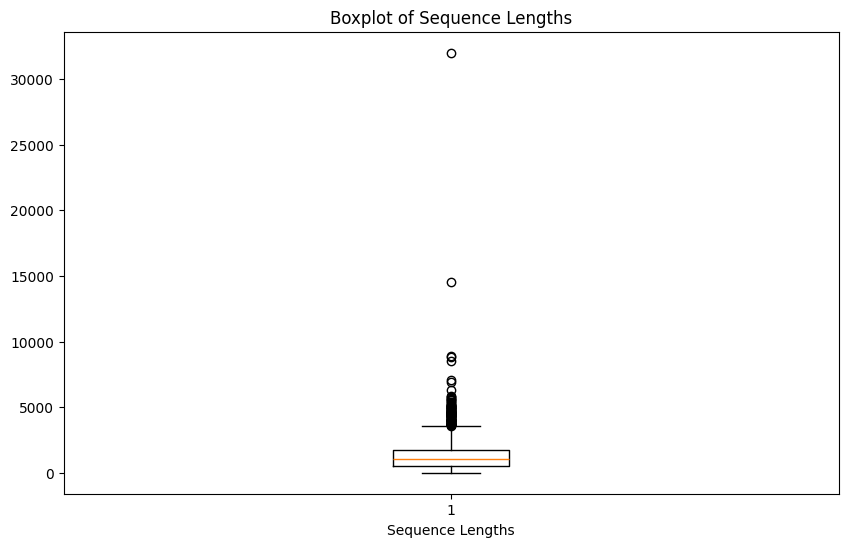

Outliers: [ 4563  4544  3695  4753  4116  4834  4349  4911  4303  4486  5005  4624
  5635  4377  4700  3926  3707  5537  4493  5202  4024  4128  3674  7081
  4684  4707  5142  3708  4374  3907  4646  3957  6907  4022  5038  3859
  5795  5430  3685  4967  8797  4061  5596  4074  3631  4391  5183  3664
  4416  3623  5890  4243  4579  4158  4599  3801  4462  5121  4981 14507
  6306  4861  4857  4069  4265  3661  4588  5058  5412  4012  4439  3972
  5762  5335  4678  8923  3953  4427  3795  5207 32000  4516  4388  3843
  4204  4168  8560  5088  5059  5654  4870  4471  3703  3753  4655  4314
  3616]


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Convert keys to a numpy array
keys_array = np.array(keys)

# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(keys_array)
plt.xlabel('Sequence Lengths')
plt.title('Boxplot of Sequence Lengths')
plt.show()

# Calculate the outliers
Q1 = np.percentile(keys_array, 25)
Q3 = np.percentile(keys_array, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = keys_array[(keys_array < lower_bound) | (keys_array > upper_bound)]
print("Outliers:", outliers)

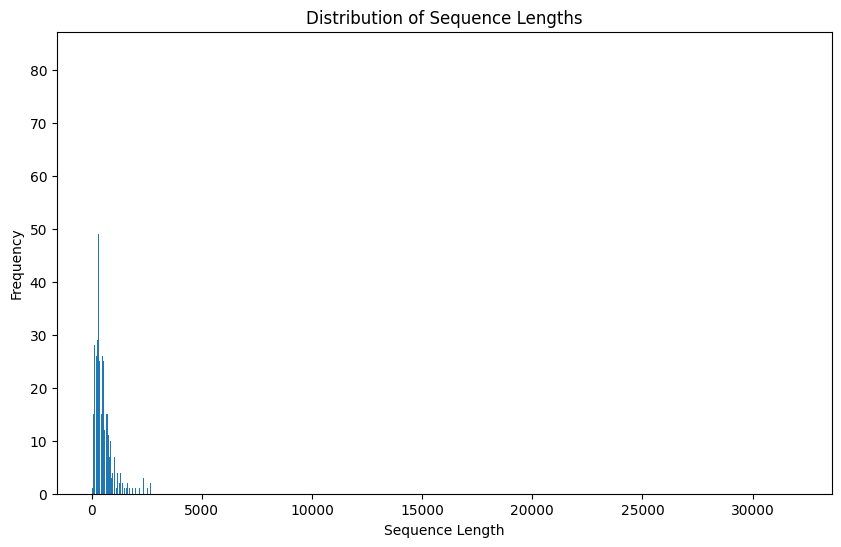

In [ ]:
import matplotlib.pyplot as plt

# Extract keys and values from len_dict
keys = list(len_dict.keys())
values = list(len_dict.values())

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(keys, values)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [ ]:
with open('./len_dict_human.pkl', 'wb') as f:
    pickle.dump(len_dict, f)



In [ ]:
pickle.load(open('./len_dict.pkl', 'rb'))

{429: 77724,
 203: 123576,
 1140: 3957,
 650: 22312,
 579: 33287,
 85: 112172,
 380: 85838,
 241: 116868,
 180: 121338,
 441: 68599,
 311: 119498,
 144: 135886,
 229: 122164,
 132: 130342,
 717: 17754,
 292: 121686,
 217: 126627,
 255: 133410,
 201: 125327,
 439: 68873,
 208: 125299,
 345: 101676,
 214: 123409,
 248: 126667,
 549: 39778,
 552: 39386,
 115: 121417,
 120: 123653,
 234: 117988,
 333: 112422,
 1012: 5771,
 118: 126227,
 134: 126901,
 116: 124428,
 262: 123119,
 244: 118395,
 150: 138665,
 222: 121944,
 724: 17418,
 108: 121364,
 81: 108606,
 499: 54332,
 276: 116280,
 179: 123701,
 191: 120912,
 173: 117709,
 164: 126354,
 167: 122901,
 425: 76531,
 245: 122137,
 417: 80340,
 238: 117791,
 143: 137540,
 464: 65530,
 314: 117726,
 252: 128258,
 212: 125254,
 207: 124473,
 233: 120643,
 281: 115088,
 296: 120840,
 343: 104229,
 71: 109609,
 594: 30997,
 721: 17481,
 506: 52134,
 152: 135723,
 275: 117240,
 278: 114004,
 309: 122945,
 253: 131822,
 135: 127697,
 408: 77867,
 